In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite 
import csv
%matplotlib inline

In [2]:
db_data = pd.read_csv("uniprotlinks.csv")
unip_data = pd.read_csv("uniprot-all2.csv")

In [3]:
df = db_data.rename(columns={'Name': 'Drug Name', 'UniProt Name': 'Protein Name'})
df_2 = unip_data.rename(columns={'Entry': 'UniProt ID', 'Protein names': 'Protein Name', 'Gene names': 'Gene Symbol'})

In [4]:
##Chaning the type of column "Gene Symbol" to list. 

Gene_sym = df_2["Gene Symbol"].tolist()

In [5]:
##Splitting data into list of lists using space delimiter. 
what_i_want = []
for id_ in Gene_sym:
    temp = str(id_).split(' ')
    what_i_want.append(temp)
    

In [6]:
#Trimming off Gene Symbol Aliases 

what_i_actually_want = [id_pair[0] for id_pair in what_i_want]  ##list comprehensions 

In [7]:
s = pd.Series(what_i_actually_want)  ##turning the list of values into a series.
df_2['Gene Symbol'] = s.values   ##adding that series to the dataframe. 

In [8]:
##Using merge to merge two dataframes and map the UniProt Id to Gene Symbol. 

combined_df = db_data.merge(df_2, how="left")

In [9]:
##rename 'Name' column in combined_df to 'Drug Name' and 'Type' column to 'Drug Type'.

combined_df2 = combined_df.rename(columns={'Name': 'Drug Name', 'Type': 'Drug Type', 'UniProt Name': 'Protein Names'})
del combined_df2["Protein Name"]

In [10]:
gene_sym = combined_df2["Gene Symbol"]
gene_sym_isnull = pd.isnull(gene_sym)
gene_sym_nulltrue = gene_sym[gene_sym_isnull]
gene_sym_nullfalse = gene_sym[gene_sym_isnull == False]

In [11]:
print(len(gene_sym_nulltrue))

4140


In [12]:
gene_sym_nullfalse.shape

(12028,)

In [13]:
##Dropping rows with empty columns in Gene Symbol. 

combined_df2.dropna(subset=['Gene Symbol'], inplace=True)

In [14]:
combined_df2.to_csv('drug_gene.tsv', sep='\t')

In [15]:
combined_df2.to_csv('drug_gene.csv')

In [16]:
combined_df2.shape

(12028, 7)

In [17]:
B = nx.Graph()

In [18]:
B.add_nodes_from(combined_df2['Drug Name'], bipartite=0)

B.add_nodes_from(combined_df2['Gene Symbol'], bipartite=1)

B.add_edges_from([(row['Drug Name'], row['Gene Symbol']) for idx, row in combined_df2.iterrows()])

In [19]:
edgelist = B.edges()

In [20]:
#separating the two sets of nodes: drugs and genes. 

d, g = bipartite.sets(B)

In [21]:
len(d)
#list(d)                """to display drugs"""

4923

In [22]:
len(g)
#list(g)                   """to display genes"""

2268

In [23]:
#degree distrubtion of drug nodes. 
d_degree = B.degree(d)

#degree distribution of gene nodes. 
g_degree = B.degree(g)

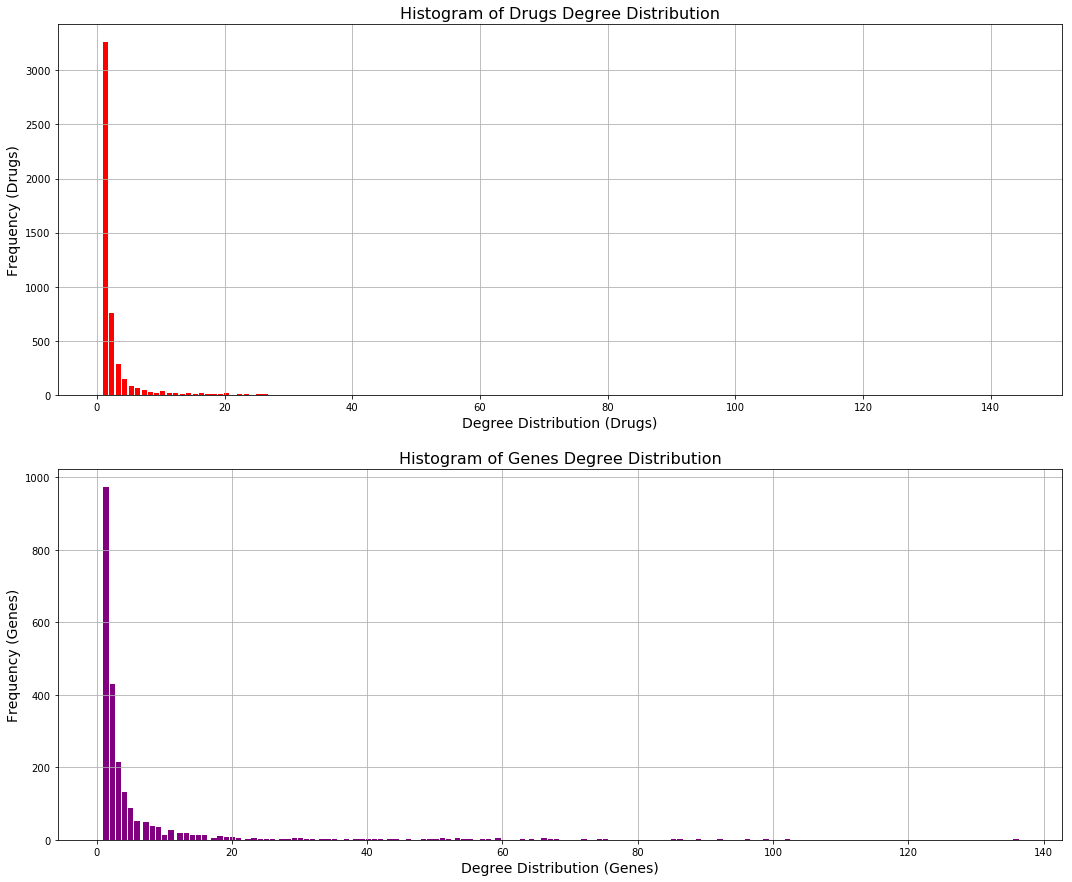

In [24]:
fig = plt.figure(figsize=(18,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
d_ax1 = [item[1] for item in list(d_degree.items())]      ##genes
g_ax2 = [item[1] for item in list(g_degree.items())]    ##drugs

ax1.set_xlabel('Degree Distribution (Drugs)', size=14)
ax1.set_ylabel('Frequency (Drugs)', size=14)
ax1.set_title('Histogram of Drugs Degree Distribution', size=16)
ax1.hist(d_ax1, bins='auto', color='red', rwidth=5, width=0.8)

ax2.set_xlabel('Degree Distribution (Genes)', size=14)
ax2.set_ylabel('Frequency (Genes)', size=14)
ax2.set_title('Histogram of Genes Degree Distribution', size=16)
ax2.hist(g_ax2, bins='auto', color='purple', rwidth=5, width=0.8)


ax1.grid(True)
ax2.grid(True)
plt.savefig('drug_gene.png')
plt.show()


In [25]:
string = pd.read_csv("HumanStringNet.txt", delimiter="\t", header=None)
string.head()

,0,1,2
0,M6PR,PLIN3,0.903
1,ESRRA,SIRT1,0.946
2,ESRRA,NRF1,0.956
3,ESRRA,NRBP1,0.911
4,ESRRA,NR1D1,0.909


In [26]:
string_df = string.rename(columns={0: 'Gene Name', 1: 'Interacting Gene', 2: 'Interaction Weight'})

In [27]:
string_df['Gene_Gene'] = string_df[['Gene Name', 'Interacting Gene']].apply(tuple, axis=1)
string_df.head()

,Gene Name,Interacting Gene,Interaction Weight,Gene_Gene
0,M6PR,PLIN3,0.903,"(M6PR, PLIN3)"
1,ESRRA,SIRT1,0.946,"(ESRRA, SIRT1)"
2,ESRRA,NRF1,0.956,"(ESRRA, NRF1)"
3,ESRRA,NRBP1,0.911,"(ESRRA, NRBP1)"
4,ESRRA,NR1D1,0.909,"(ESRRA, NR1D1)"


In [28]:
edges = string_df["Gene_Gene"].tolist()

In [29]:
G = nx.Graph()
G.add_edges_from(edges)
degree = G.degree()

In [30]:
len(G.edges())

160249

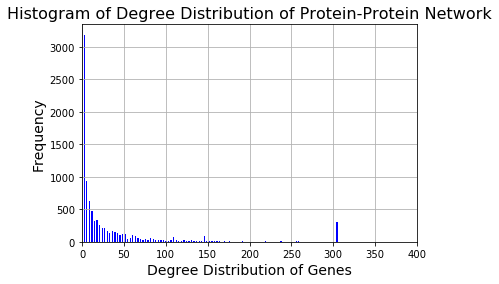

In [31]:
plt.xlabel('Degree Distribution of Genes', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Histogram of Degree Distribution of Protein-Protein Network', size=16)
#plt.ylim(0,2000)
plt.xlim(0,400)

degrees = [item[1] for item in list(degree.items())]

plt.hist(degrees, bins='auto', color='blue', rwidth=0.5)
plt.grid(True)
plt.savefig('stringnetwork.png')                                         #do savefig before show()!
plt.show()

In [32]:
string_df.to_csv('stringnetwork.tsv', sep='\t')
string_df.to_csv('stringnetwork.csv')

In [33]:
drug_list = pd.read_csv("donor_therapy.tsv", delimiter="\t")

In [34]:
#dropping rows with NaN values in other_therapy column. 
drug_col = drug_list["other_therapy"]
drug_col_isnull = pd.isnull(drug_col)
drug_col_nullfalse = drug_col[drug_col_isnull == False]
drug_list.dropna(subset=['other_therapy'], inplace=True)

#dropping rows with 'unknonwn' values in other_therapy column. 
drug_list1 = drug_list[drug_list.other_therapy.str.contains("unknown") == False]

#not_unknown = [x == 'unknown' for x in drug_list['other_therapy']]

In [35]:
#dict_ = dict(string_df['Gene_Gene'])
#dict_ = dict(edges)
#import itertools
#d = dict(itertools.zip_longest(*[iter(egfr)] * 2, fillvalue=""))
#path = nx.shortest_path_length(G, source='EGFR', target='ESRRA')

In [36]:
max(degree, key=degree.get)  
degree['UBC']

1746

In [37]:
egfr = G.neighbors('EGFR')
print(type(egfr))

<class 'list'>


In [38]:
G.degree('EGFR')

223

In [39]:
nadh = B.neighbors('NADH')
B.degree('NADH')

144

In [41]:
f = open('stringnetwork.csv')
csvreader = csv.reader(f)
string_data = list(csvreader)

class String:
    def __init__(self, column):
        self.gene = column[0]
        self.interacting_gene = column[1]
        self.weight = column[2]
    def __init__(self,data):
        self.data = data
string_network = String(string_data)    
def get_gene(self):
    return(self.interacting_gene)

In [42]:
def subgraph(self, nbunch):
    bunch = self.nbunch_ter(nbunch)
    H = self.__class__()
    for n in bunch:
        H.node[n] = self.node[n]
        for n in bunch:
            H.node[n] = self.node[n]
        H_adj = H.adj
        self_adj = self.adj
        for n in H.node:
            Hnbrs = H.adjlist_dict_factory()
            H_adj[n] = Hnbrs
            for nbr, d in self_adj[n].items():
                if nbr in H_adj:
                    Hnbrs[nbr] = d
                    H_adj[nbr][n] = d
        H.graph = self.graph
        return H
        

In [74]:
#nx.ego_graph(G, "M6PR")
#nx.write_graphml(G,'test.gml')

In [89]:
def draw_neighbors(G, node, with_labels=True, **kwds):
    neighbors = []
    for nodes in G.neighbors(node):
        neighbors.append(nodes)
        if nodes in neighbors:
            nx.draw_networkx(G, neighbors)
            return neighbors
            return G
        plt.show()
        

TypeError: list indices must be integers or slices, not str

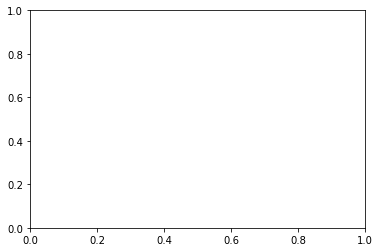

In [91]:
draw_neighbors(G, "EGFR")